In [1]:
from datetime import datetime, timedelta
import re
import sqlite3
import time
import os
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
import ast
from sqlalchemy import MetaData, text, Column, Integer, String, ForeignKey, Table, create_engine, Float, Boolean, DateTime

In [2]:
import optimize_lineup
from player_projections.fantasy_projections import FantasyProjections

In [3]:
fp = FantasyProjections(data_dir="player_projections/data", year=2026)

In [4]:
players = fp.player_index

In [ ]:
#fp.proj_systems = ['cbs', 'atc', 'steamer', 'oopsy']
#df = fp.generate_auction_values()
#keepers = pd.read_csv('player_projections/data/2026-keepers.csv')
#fp.draft_values = fp.draft_values.merge(keepers, on='cbsid', how='left', suffixes=[None,'_keeper'])
#fp.draft_values['Paid'] = None
#fp.draft_values['Supp'] = None
#fp.draft_values['Keeper'] = None
#fp.draft_values.fillna({'Owner':fp.draft_values['Owner_keeper'], 'Paid':fp.draft_values['Paid_keeper'], 'Supp':fp.draft_values['Supp_keeper'], 'Timestamp':fp.draft_values['Timestamp_keeper'], 'Keeper':fp.draft_values['Keeper_keeper']}, inplace=True)
#fp.draft_values.drop(columns=['Owner_keeper', 'Paid_keeper', 'Supp_keeper', 'Timestamp_keeper', 'Keeper_keeper'],inplace=True)
#fp.save_to_database('players')

In [5]:
engine = create_engine('sqlite:///fantasy_data.db', echo=False)

# Q1
### Who had the best draft results?
Plan: Analyze value of actual results from the full season. Only consider the value from the optimized drafted lineup for each owner. Surplus value isn't important since we all have roughly the same dollars to start with. How a team performed in the draft should be based on the best team that would actually start. It could be fine to use the entire team since that gets to depth, but I think that adds clip away so many bad draft picks that it's more instructive to focus on the best 23 by position.

In [6]:
df2 = fp.evaluate_season_performance()

MODE 2: EVALUATING SEASON PERFORMANCE
Found 233 qualifying hitters (PA >= 363)
Found 237 qualifying pitchers


In [7]:
draft = pd.read_sql("SELECT cbsid, Name CBSNAME, Owner, Paid, Supp, Value Value_proj FROM players2025 WHERE Owner IS NOT NULL", engine)
draft = draft.merge(df2, on='cbsid', how='left', suffixes=[None,'_eval'])
draft.fillna({'Value':-10},inplace=True)
draft['val_clip'] = draft['Value'].clip(lower=-10)
draft['surplus'] = draft['val_clip'] - draft['Paid']
draft = draft[~((draft['CBSNAME']=='Shohei Ohtani') & (draft['PA'].isna()))]
draft['type'] = draft['PA'].apply(lambda x: 'p' if pd.isnull(x) else 'h')
draft['Drop Week'] = 27
draft.shape

(396, 56)

In [8]:
draft.groupby('Owner')['cbsid'].count()

Owner
9 Grand Kids    33
Brewbirds       33
Charmer         33
Dirty Birds     33
Harvey          33
Lima Time       33
Mother          33
Roid Ragers     33
Trouble         33
Ugly Spuds      33
Wu-Tang         33
Young Guns      33
Name: cbsid, dtype: int64

In [9]:
draft.groupby('Owner')['surplus'].describe()['75%'].sort_values(ascending=False)

Owner
Ugly Spuds      8.7
Harvey          7.0
Charmer         1.0
Brewbirds       0.5
Lima Time      -0.1
Trouble        -0.3
Dirty Birds    -1.0
Mother         -2.1
9 Grand Kids   -4.4
Young Guns     -4.7
Wu-Tang        -6.0
Roid Ragers    -9.4
Name: 75%, dtype: float64

<Axes: xlabel='Owner'>

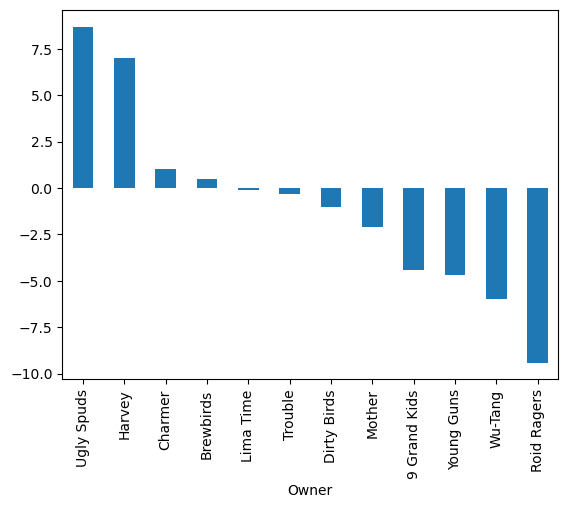

In [10]:
draft.groupby('Owner')['surplus'].describe()['75%'].sort_values(ascending=False).plot(kind='bar')

In [11]:
draft_results = {}
for owner in draft.Owner.unique():
    opt = optimize_lineup.Optimized_Lineups(owner=owner, data=draft, optimize_col=['Value'], player_col='CBSNAME', pos_col='Pos')
    opt.optimize()
    draft_results[owner] = opt.hitter_optimized_z + opt.pitcher_optimized_z

<Axes: >

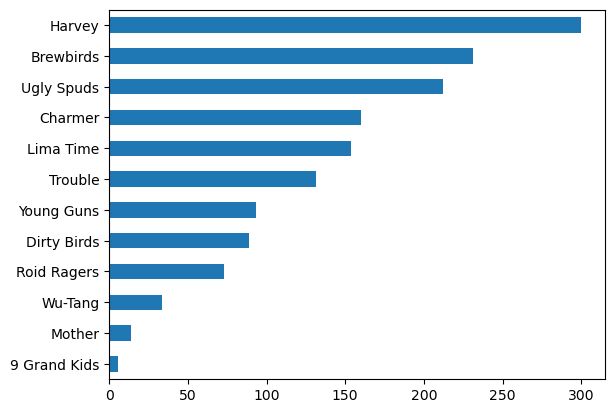

In [12]:
pd.Series(draft_results).sort_values(ascending=True).plot(kind='barh')

# Q2
### Which players were the best/worst deals?
Measured by surplus value

<Axes: ylabel='CBSNAME'>

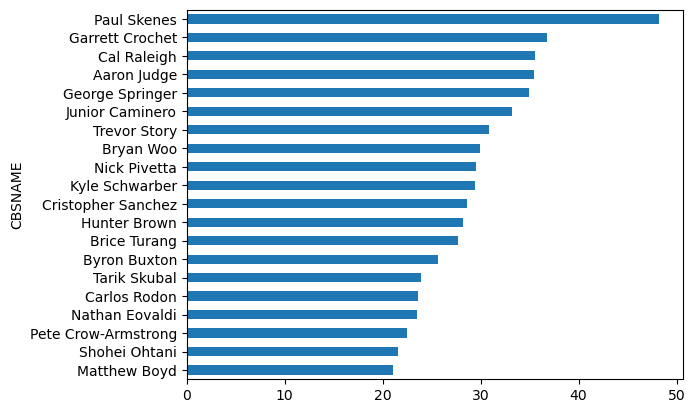

In [13]:
draft.sort_values('surplus', ascending=True).set_index('CBSNAME')['surplus'].tail(20).plot(kind='barh')

<Axes: ylabel='CBSNAME'>

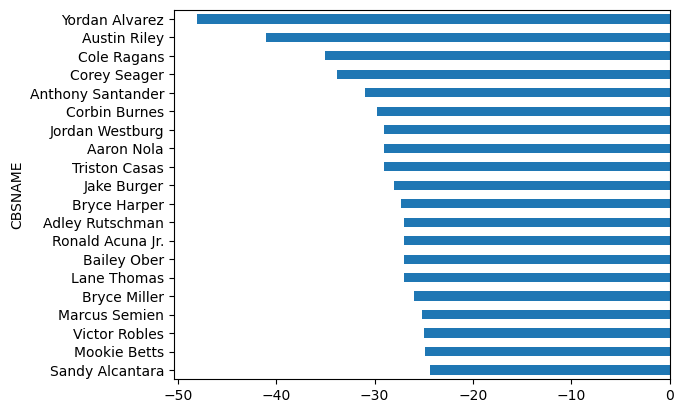

In [14]:
draft.sort_values('surplus', ascending=False).set_index('CBSNAME')['surplus'].tail(20).plot(kind='barh')

# Q3
### Where did each team's value come from?
Sources: Draft, FA Adds, and Trades

In [15]:
owner_name_change = {'Trouble With The Curve':'Trouble', 'Harveys Wallbangers':'Harvey', 'Lima Time!':'Lima Time', 'Brewbirds':'Brewbirds', 'Charmer':'Charmer', 'Roid Ragers':'Roid Ragers', 'Dirty Birds':'Dirty Birds', 'Young Guns':'Young Guns',
                    'Ugly Spuds':'Ugly Spuds', "Mom's Cookin":'Mother', '9 Grand Kids':'9 Grand Kids', 'Lil Trumps Wiscompton Wu-Tang':'Wu-Tang'}

In [16]:
roster = pd.read_sql(f"""
    SELECT 
        r.cbsid, p.CBSNAME Name, o.owner, r.owner_id, r.week, r.decision, d.cbsid draft_id, d.Paid, d.Supp,
        CASE
            WHEN d.Paid > 0 THEN 'draft'
            WHEN d.Supp > 0 THEN 'draft'
            ELSE NULL
        END as source,
        s.AB PA, s.R, s.RBI, s.HR, s.SB, s.H, s.AB, s.W, s.QS, s.SO, s.SvHld, s.ER, s.Ha HA, s.BBa BB, s.IP, s.outs,
        e.all_pos Pos,
        CASE
            WHEN e.posDH > 0 THEN 'h'
            ELSE 'p'
        END As ptype
    FROM roster r
    LEFT JOIN stats s On (r.cbsid=s.cbsid AND r.year=s.year AND r.week=s.week)
    LEFT JOIN players{datetime.now().year-1} d On (r.cbsid=d.cbsid)
    LEFT JOIN players p On (r.cbsid=p.cbsid)
    LEFT JOIN owners o On (r.owner_id=o.owner_id)
    LEFT JOIN eligibility e On (r.cbsid=e.cbsid AND r.year=e.year AND r.week=e.week)
    WHERE 
        r.year={datetime.now().year-1}
    """, engine)
roster.shape

(11088, 28)

In [17]:
# Make sure each owner has 33 players each week
pd.pivot_table(roster, index='owner_id', columns='week', values='cbsid', aggfunc='count')

week,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
owner_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
3,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
4,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
29,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
30,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
36,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
38,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
41,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
42,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33


In [18]:
adds = pd.read_csv(r'player_projections\data\2025-adds.csv')
adds['week'] = adds['period'] + 1
#adds['Drop Week'] = adds['Drop Week'] + 1
#adds['Drop Week'] = adds['Drop Week'].clip(upper=28)
adds['Owner'] = adds['owner'].apply(lambda x: owner_name_change[x])

In [19]:
for i, row in adds.sort_values('week').iterrows():
    #print(row['cbsid'], row['owner_id'], row['Add'], row['week'], row['Drop Week'])
    mask = (roster['owner_id']==row['owner_id']) & (roster['cbsid']==row['cbsid']) & (roster['week'].between(row['week'],row['Drop Week']))
    roster.loc[mask, 'source'] = 'FA'

In [20]:
trades = pd.read_csv(r'player_projections\data\2025-trades.csv')
trades['week'] = trades['period'] + 1

In [21]:
traded_pairs: set = set()
for _, row in trades.iterrows():
    if pd.isna(row.get('owner_id')):
        continue
    recv_oid = int(row['owner_id'])
    recv_week = int(row['week'])
    try:
        for p in ast.literal_eval(row['parsed_transactions']):
            cid = int(roster.loc[(roster['Name']==p['Name']) & (roster['owner_id']==recv_oid) & (roster['week']==recv_week), 'cbsid'].iloc[0])
            #print(_, recv_oid, recv_week, cid)
            try:
                drop_week = int(adds[(adds['owner_id']==recv_oid) & (adds['Drop']==p['Name'])]['week'].iloc[0])
            except:
                drop_week = 28
            #print(recv_oid, recv_week, cid, drop_week)
            roster.loc[(roster['Name']==p['Name']) & (roster['owner_id']==recv_oid) & (roster['week'].between(recv_week, drop_week)),'source'] = 'trade'
            #cid = _lookup_cbsid(p['Name'], p.get('Position', ''))
            if cid is not None:
                traded_pairs.add((cid, recv_oid))
    except Exception:
        print('exception occurred for',_, row['parsed_transactions'])
        pass

In [22]:
roster.loc[(roster['Paid'].isna()) & (roster['source'].isna()), 'source'] = 'FA'

In [23]:
roster.groupby(['owner', 'source'])['cbsid'].count().unstack().sort_values('draft')

source,FA,draft,trade
owner,,,
Mom's Cookin,250.0,550.0,124.0
Harveys Wallbangers,185.0,556.0,183.0
Wiscompton Wu-Tang,234.0,587.0,103.0
9 Grand Kids,269.0,648.0,7.0
Trouble with the Curve,171.0,658.0,95.0
Charmer,219.0,659.0,46.0
Lima Time!,153.0,681.0,90.0
Ugly Spuds,214.0,684.0,26.0
Brewbirds,220.0,686.0,18.0


In [24]:
owner_sb = roster.groupby(['owner', 'source'])['SB'].count().unstack().sort_values('draft').fillna(0)
owner_sb['total'] = owner_sb.sum(axis=1)
for col in ['FA', 'draft', 'trade']:
    owner_sb[col+'%'] = owner_sb[col] / owner_sb['total']

owner_sb_rank = roster[roster['decision']=='start'].groupby('owner')['SB'].sum().rank()
owner_sb = owner_sb.merge(owner_sb_rank, left_index=True, right_index=True, how='inner')
for col in ['FA%', 'draft%', 'trade%']:
    owner_sb[col+'_SGP'] = owner_sb['SB'] * owner_sb[col]
owner_sb

,FA,draft,trade,total,FA%,draft%,trade%,SB,FA%_SGP,draft%_SGP,trade%_SGP
owner,,,,,,,,,,,
Mom's Cookin,119.0,296.0,69.0,484.0,0.245868,0.611570,0.142562,9.0,2.212810,5.504132,1.283058
Harveys Wallbangers,71.0,324.0,87.0,482.0,0.147303,0.672199,0.180498,7.0,1.031120,4.705394,1.263485
Wiscompton Wu-Tang,68.0,353.0,69.0,490.0,0.138776,0.720408,0.140816,2.0,0.277551,1.440816,0.281633
9 Grand Kids,179.0,364.0,0.0,543.0,0.329650,0.670350,0.000000,3.0,0.988950,2.011050,0.000000
Charmer,83.0,371.0,45.0,499.0,0.166333,0.743487,0.090180,12.0,1.995992,8.921844,1.082164
Lima Time!,58.0,376.0,49.0,483.0,0.120083,0.778468,0.101449,7.0,0.840580,5.449275,0.710145
Trouble with the Curve,93.0,382.0,36.0,511.0,0.181996,0.747554,0.070450,7.0,1.273973,5.232877,0.493151
Ugly Spuds,126.0,383.0,26.0,535.0,0.235514,0.715888,0.048598,10.5,2.472897,7.516822,0.510280
Brewbirds,117.0,391.0,4.0,512.0,0.228516,0.763672,0.007812,10.5,2.399414,8.018555,0.082031


# Q4
### Who won their trades?

# Q5
### Who got the most from their team each week?
Answers the question of who extracted the most value from their roster on a week by week basis